In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from sklearn.preprocessing import MultiLabelBinarizer
import ast
import seaborn as sns

In [2]:
# Load the datasets
train_data = pd.read_csv('./Data/train.csv', parse_dates=['host_since', 'first_review', 'last_review'])

ame = train_data[['amenities','price']].copy()
# convert the amenities column to list
ame['amenities'] = ame['amenities'].apply(ast.literal_eval)
# count the number of amenities in each row
count = ame['amenities'].explode().value_counts()

# extract the popular amenities that counts more than 100
popular_amenities = count[count > 100].index
print(popular_amenities)

# Filter out the amenities to include only popular ones
ame.loc[:,'filtered_amenities'] = ame['amenities'].apply(lambda x: [amenity for amenity in x if amenity in popular_amenities])

# Use MultiLabelBinarizer to one-hot encode amenities
mlb = MultiLabelBinarizer()
encoded_amenities = pd.DataFrame(mlb.fit_transform(ame['filtered_amenities']), columns=mlb.classes_, index=ame.index)

# Concatenate the original DataFrame with the new encoded amenities DataFrame
ame = pd.concat([ame.drop(columns=['amenities', 'filtered_amenities']), encoded_amenities], axis=1)

Index(['Smoke alarm', 'Wifi', 'Carbon monoxide alarm', 'Kitchen', 'Hot water',
       'Essentials', 'Hangers', 'Hair dryer', 'Iron', 'Refrigerator',
       ...
       'Exercise equipment: free weights, yoga mat', 'Outdoor playground',
       'Housekeeping - available at extra cost', 'Stainless steel stove',
       'Paid parking lot off premises', 'Coffee maker: espresso machine',
       'Clothing storage: walk-in closet and closet',
       'Exercise equipment: yoga mat', 'EV charger', 'Private hot tub'],
      dtype='object', name='amenities', length=180)


In [3]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

ame_target = ame['price']
ame_features = ame.drop(columns=['price'])

xgb_model = xgb.XGBRegressor()
xgb_reg = GridSearchCV(xgb_model, {'max_depth': [2,4,6], 'n_estimators': [50,100,200]}, cv = 5, scoring='neg_root_mean_squared_error')
xgb_reg.fit(ame_features, ame_target)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'max_depth': [2, 4, 6],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_root_mean_squared_error')

In [4]:
# Get the booster from the best estimator
booster = xgb_reg.best_estimator_.get_booster()

# Get feature importance by 'weight' (frequency)
feature_importance_weight = booster.get_score(importance_type='weight')

# Get feature importance by 'gain'
feature_importance_gain = booster.get_score(importance_type='gain')

# Convert to DataFrames for easy viewing
import pandas as pd

feature_importance_weight_df = pd.DataFrame(list(feature_importance_weight.items()), columns=['feature', 'importance_weight'])
feature_importance_gain_df = pd.DataFrame(list(feature_importance_gain.items()), columns=['feature', 'importance_gain'])

# Sort the DataFrames by importance
feature_importance_weight_df = feature_importance_weight_df.sort_values(by='importance_weight', ascending=False)
feature_importance_gain_df = feature_importance_gain_df.sort_values(by='importance_gain', ascending=False)

# get the top30 feature importance by 'weight'
top30_weight = feature_importance_weight_df.head(30)
# get the top30 feature importance by 'gain'
top30_gain = feature_importance_gain_df.head(30)

print(top30_weight['feature'].values)
print(top30_gain['feature'].values)

['Air conditioning' 'Dedicated workspace' 'Bathtub' 'First aid kit'
 'Bed linens' 'Lock on bedroom door' 'Fire extinguisher'
 'Exterior security cameras on property' 'TV' 'Hair dryer' 'Coffee maker'
 'Iron' 'Pets allowed' 'Carbon monoxide alarm' 'Long term stays allowed'
 'Body soap' 'Luggage dropoff allowed' 'BBQ grill' 'Private entrance'
 'Free street parking' 'Lockbox' 'Baking sheet' 'Dishwasher' 'Essentials'
 'Refrigerator' 'Extra pillows and blankets' 'Shampoo'
 'Room-darkening shades' 'Hot water' 'Washer']
['Lock on bedroom door' 'Gym' 'Hair dryer' 'Hot tub' 'Crib' 'Dishwasher'
 'Shampoo' 'Pets allowed' 'Elevator' 'Building staff'
 'Free street parking' 'Wine glasses'
 'Pack ’n play/Travel crib - available upon request' 'Heating' 'Kitchen'
 'Safe' 'Outdoor dining area' 'Pack ’n play/Travel crib'
 'Dishes and silverware' 'Paid parking on premises' 'Indoor fireplace'
 'Hot water' 'Private patio or balcony' 'Essentials' 'City skyline view'
 'Self check-in' 'Paid parking garage off p

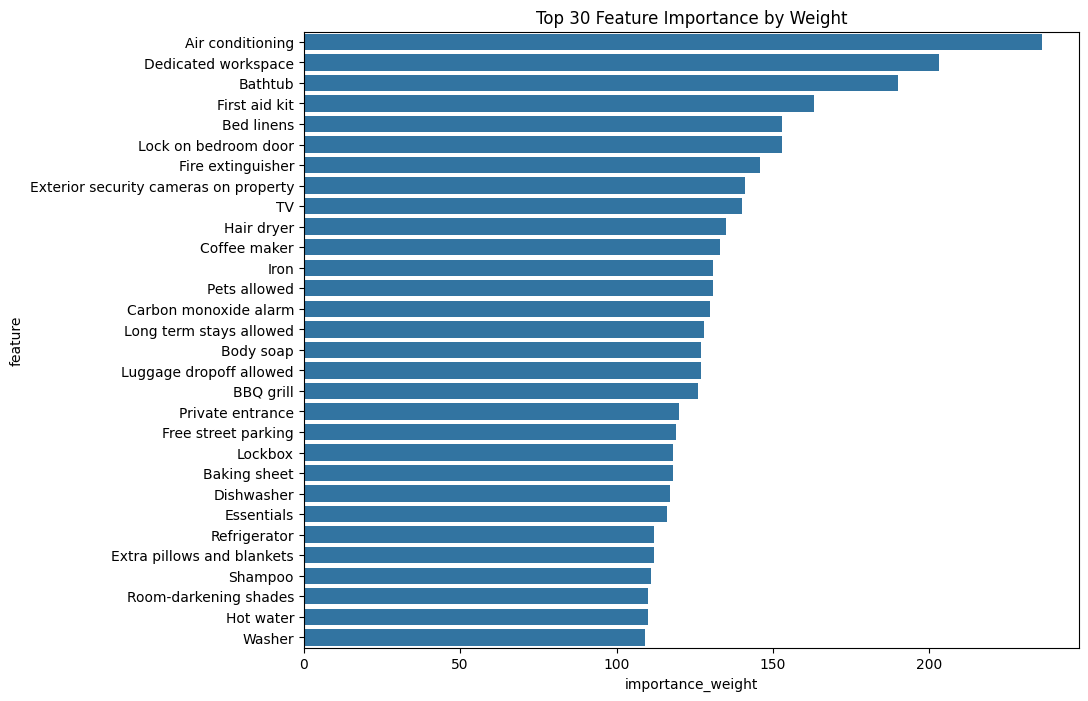

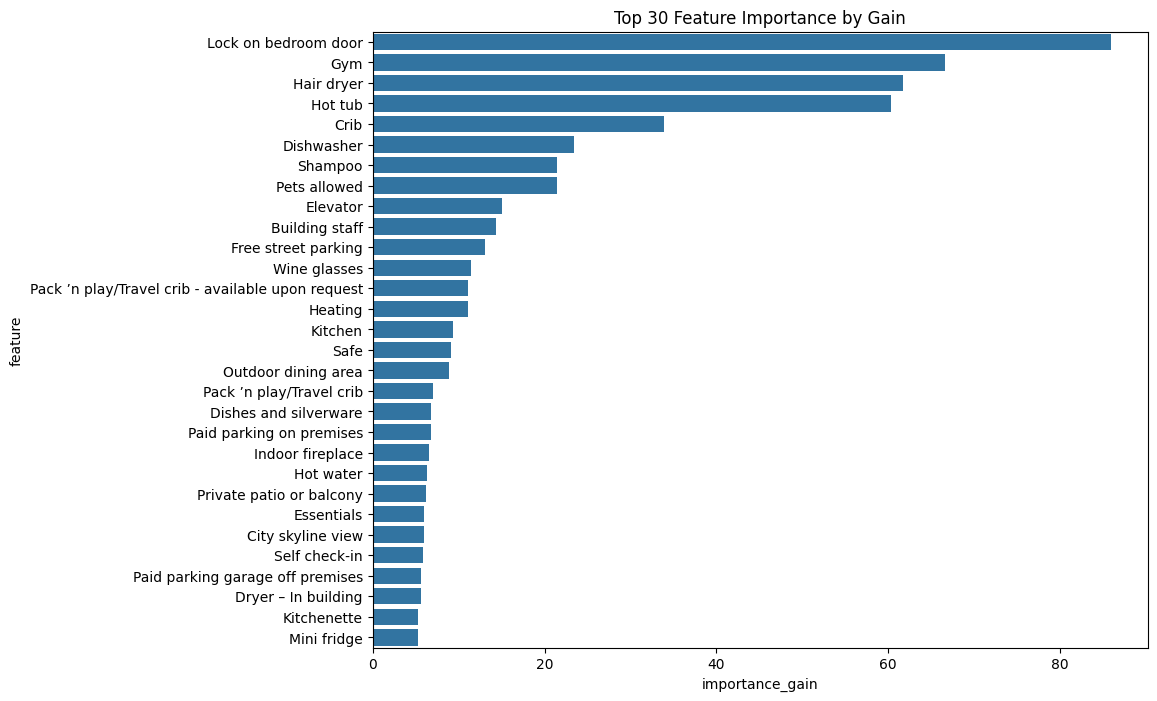

In [5]:
# Plot the feature importance by 'weight'
plt.figure(figsize=(10, 8))
sns.barplot(x='importance_weight', y='feature', data=top30_weight)
plt.title('Top 30 Feature Importance by Weight')
plt.show()

# Plot the feature importance by 'gain'
plt.figure(figsize=(10, 8))
sns.barplot(x='importance_gain', y='feature', data=top30_gain)
plt.title('Top 30 Feature Importance by Gain')
plt.show()



Index(['Lock on bedroom door', 'Hair dryer', 'Gym', 'Crib', 'Pets allowed',
       'Elevator', 'Dishwasher', 'Shampoo', 'Iron', 'High chair', 'Essentials',
       'Self check-in', 'Bed linens', 'Building staff', 'Coffee maker',
       'Private entrance', 'Dryer – In unit', 'Washer – In unit', 'Hangers',
       'Washer – In building', 'Dryer – In building', 'Hot tub',
       'Wine glasses', 'Bathtub', 'Pack ’n play/Travel crib',
       'Long term stays allowed', 'Air conditioning', 'Free dryer – In unit',
       'Sound system', 'Babysitter recommendations'],
      dtype='object')


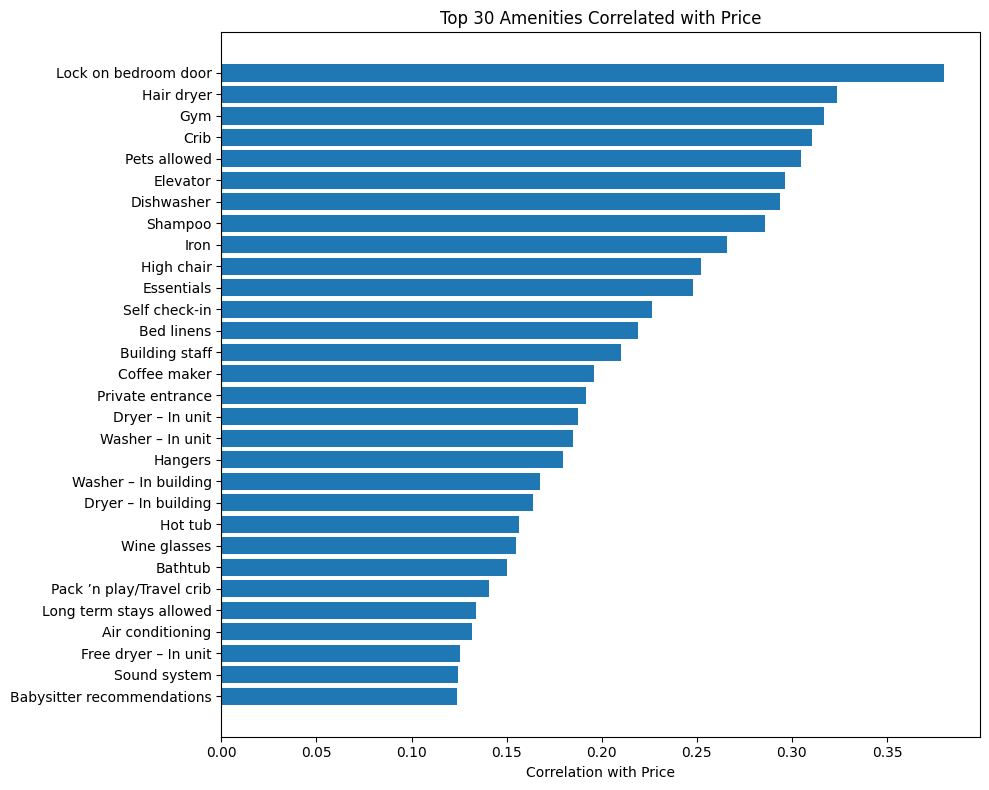

In [6]:
# calculate the absolute correlation between amenities and price and ignore self-correlation 
amenities_price_corr = ame.corr()['price'].drop('price').abs().sort_values(ascending=False)

# find the top 30 amenities that are most correlated with price
top30_corr = amenities_price_corr.head(30)

# print the top 30 amenities
print(top30_corr.index)


# plot the top 30 amenities
plt.figure(figsize=(10, 8))
plt.barh(top30_corr.index, top30_corr.values)
plt.xlabel('Correlation with Price')
plt.title('Top 30 Amenities Correlated with Price')
plt.gca().invert_yaxis()  # To show highest correlation on top
plt.tight_layout()
plt.show()

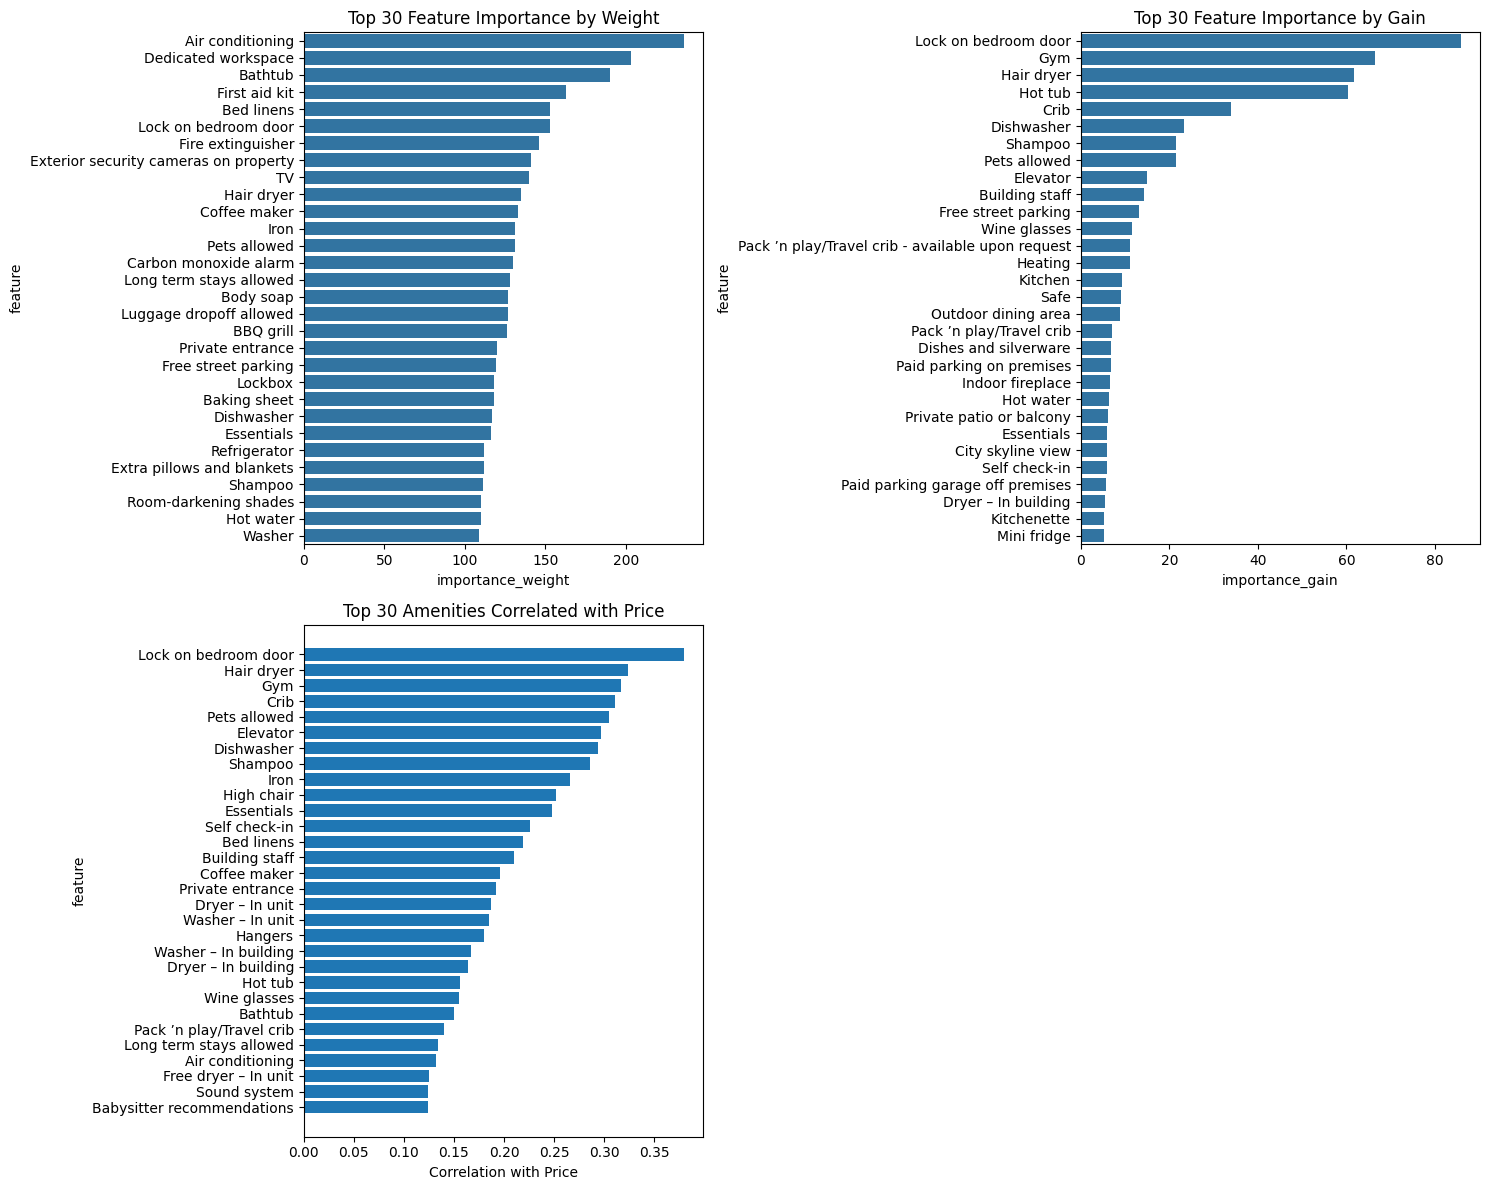

In [19]:
# plot thetop30 feature importance by 'weight' and 'gain' and top30 amenities correlation with price in one figure
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
sns.barplot(x='importance_weight', y='feature', data=top30_weight)
plt.title('Top 30 Feature Importance by Weight')

plt.subplot(2, 2, 2)
sns.barplot(x='importance_gain', y='feature', data=top30_gain)
plt.title('Top 30 Feature Importance by Gain')

plt.subplot(2, 2, 3)
plt.barh(top30_corr.index, top30_corr.values)
plt.gca().invert_yaxis()
plt.xlabel('Correlation with Price')
plt.ylabel('feature')
plt.title('Top 30 Amenities Correlated with Price')

plt.tight_layout()
plt.show()